<a href="https://colab.research.google.com/github/Laskiri/Machine-Inteligence/blob/main/Session3_Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduction


## 1.1 Goals
- Extend our regression model  routines to support multiple features
    - Extend data structures to support multiple features
    - Rewrite prediction, cost and gradient routines to support multiple features
    - Utilize NumPy `np.dot` to vectorize their implementations for speed and simplicity

<a name="toc_15456_1.2"></a>
## 1.2 Tools
In this exercise, we will make use of:
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data

In [93]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

In [94]:
def load_house_data():
    data = np.loadtxt("https://drive.google.com/uc?id=1IM7fSyvchd6MPlV_5b8wuakO09aFcw4s", delimiter=',',skiprows=1)

    X = data[:,:4]
    y = data[:,4]

    # Fix sample with zero bedrooms
    X[X[:,1]==0,1]=1

    return X, y

In [95]:
import urllib
from urllib.request import urlopen


def feedback(excercise_id, finished=True, understood=True, comment="No comments"):
  base_url = "https://docs.google.com/forms/d/e/"
  base_url += "1FAIpQLSdQwo5EswpUpJnx0cHgPdJzuiUsg7KiJMORmC5VZBSGEhjPrQ"
  base_url += "/formResponse?"
  base_url += "entry.2058183318=" + excercise_id
  base_url += "&entry.217828241=" + ("Yes" if finished else "No")
  base_url += "&entry.676697552=" + ("Yes" if understood else "No")
  base_url += "&entry.379660172=" + comment

  base_url = base_url.replace(" ", "%20")
  urlopen(base_url)
  print("FEEDBACK SUBMITTED. THANKS!!! :D")


<a name="toc_15456_1.3"></a>
## 1.3 Notation
Here is a summary of some of the notation you will encounter, updated for multiple features.  

|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train`
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at $\mathbf{x^{(i)}}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` |


# 2 Problem Statement


## 2.1 Data Set
We will use the motivating example of housing price prediction. The training data set contains many examples with 4 features (size, bedrooms, floors and age) shown in the table below. Note, in this exercise, the Size feature is in sqft while earlier exercise utilized 1000 sqft.

We would like to build a linear regression model using these values so we can then predict the price for other houses - say, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.

In [96]:
# load the dataset
X_train, y_train = load_house_data()
X_features = ['size','bedrooms','floors','age']

Let's view the dataset and its features by plotting each feature versus price.

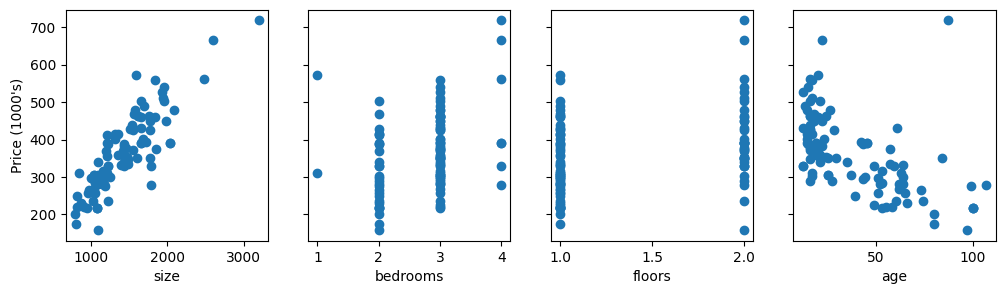

In [97]:

fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

## 2.2 Matrix X containing our examples
Similar to the table above, examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is three in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} =
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1}
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

Display the input data.

In [98]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")


X Shape: (99, 4), X Type:<class 'numpy.ndarray'>)
y Shape: (99,), y Type:<class 'numpy.ndarray'>)


<a name="toc_15456_2.2"></a>
## 2.3 Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

In [99]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


<a name="toc_15456_3"></a>
# 3 Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

In [100]:
def predict(x, w, b):
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters
      b (scalar):             model parameter

    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b
    return p

In [101]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [1.24e+03 3.00e+00 1.00e+00 6.40e+01]
f_wb shape (), prediction: -416.06094562059184


<a name="toc_15456_4"></a>
# 4 Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$


In contrast to tje previous exercise, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [102]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar
    return cost

In [103]:
# Compute and display cost using our pre-chosen optimal parameters.
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at initial w,b: {cost}')

Cost at initial w,b: 222294.8392591333


<a name="toc_15456_5"></a>
# 5 Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [104]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b.
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [105]:
#Compute and display gradient
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -59.762118071904894
dj_dw at initial w,b: 
 [ 1.47e+04 -9.89e+01  1.69e+00 -1.93e+04]


In [106]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters
      b (scalar)       : Updated value of parameter
      """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")

    return w, b, J_history #return final w,b and J history for graphing

## 5.1 Runing Gradient Descent

In [107]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 100000
alpha = 0.0000001
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(3):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 44231.26   
Iteration 10000: Cost  1372.83   


KeyboardInterrupt: 

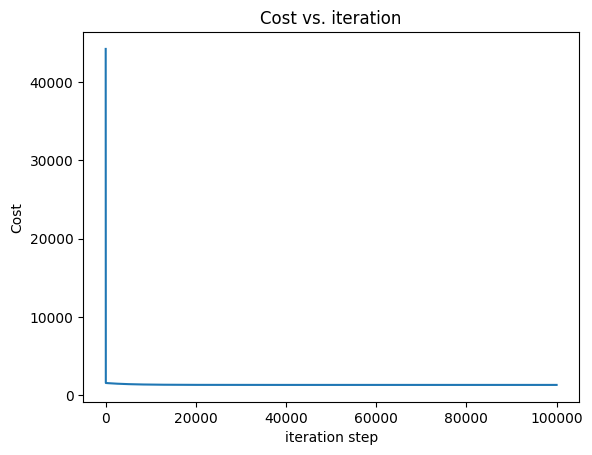

In [35]:
# plot cost versus iteration
plt.plot(J_hist)
plt.title("Cost vs. iteration")
plt.ylabel('Cost')
plt.xlabel('iteration step')
plt.show()

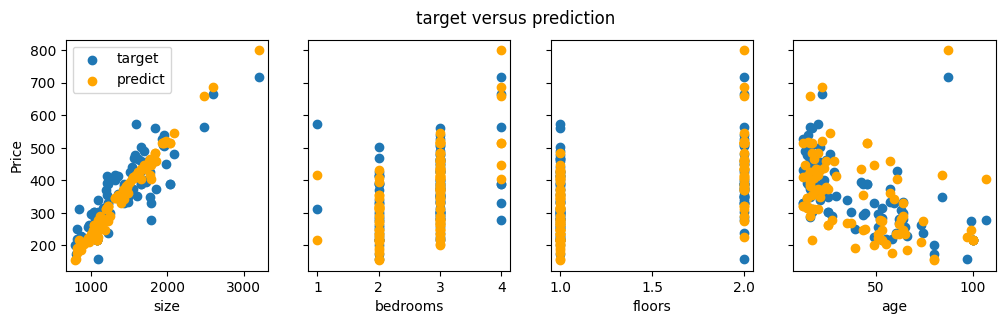

In [36]:
#predict target using normalized features
m = X_train.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_train[i], w_final) + b_final

    # plot predictions and targets versus original features
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction")
plt.show()

# 6 Feature Scaling


## 6.2 Z-score normalization

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [37]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    X_mean     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    X_sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - X_mean) / X_sigma

    return (X_norm, X_mean, X_sigma)


#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

Apply data normalization

In [38]:
X_norm, X_mean, X_sigma = zscore_normalize_features(X_train)

Plotting the data after normalization (compare with the output of Section 2.1)

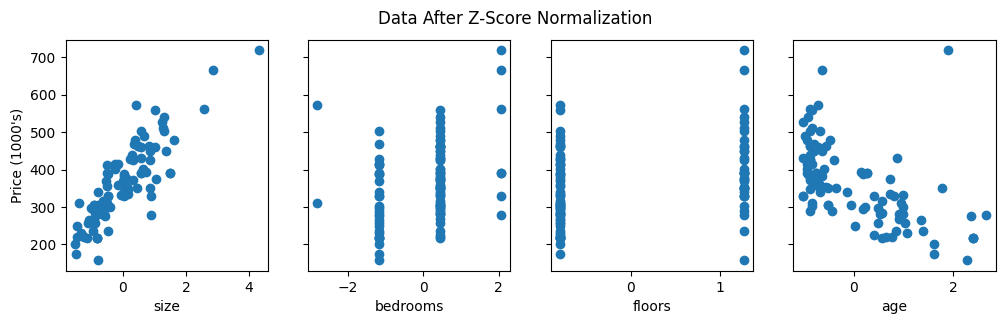

In [39]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_norm[:,i],y_train)
    ax[i].set_xlabel(X_features[i])

ax[0].set_ylabel("Price (1000's)")
fig.suptitle("Data After Z-Score Normalization")
plt.show()

## 6.2 Runing Gradient Descent after Feature Scaling

In [48]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 100
alpha = 0.78
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(3):
    print(f"prediction: {np.dot(X_norm[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost  5660.71   
Iteration   10: Cost   234.75   
Iteration   20: Cost   230.82   
Iteration   30: Cost   230.81   
Iteration   40: Cost   230.81   
Iteration   50: Cost   230.81   
Iteration   60: Cost   230.81   
Iteration   70: Cost   230.81   
Iteration   80: Cost   230.81   
Iteration   90: Cost   230.81   
b,w found by gradient descent: 363.16,[111.55 -21.11 -33.21 -38.1 ] 
prediction: 294.91, target value: 300.0
prediction: 486.62, target value: 509.8
prediction: 389.50, target value: 394.0


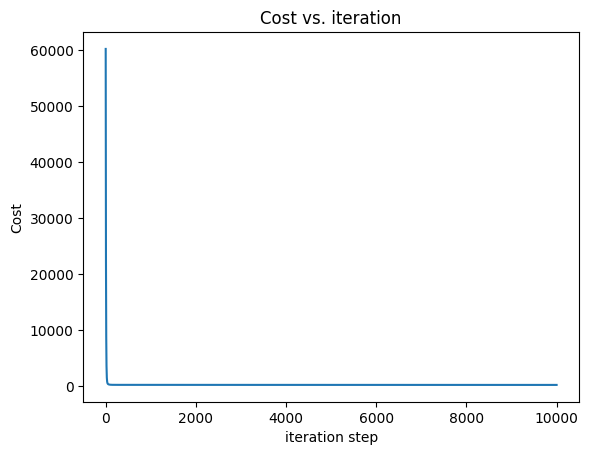

In [169]:
# plot cost versus iteration
plt.plot(J_hist[0:])
plt.title("Cost vs. iteration")
plt.ylabel('Cost')
plt.xlabel('iteration step')
plt.show()

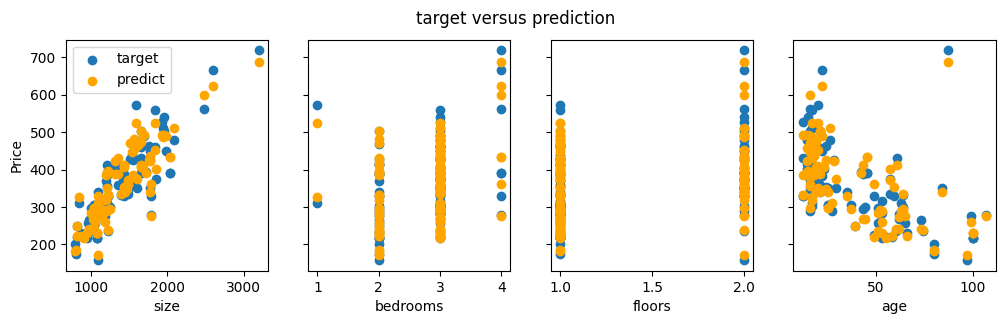

In [42]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_final) + b_final

    # plot predictions and targets versus original features
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction")
plt.show()

## Exercise 1: Explore the effect of feature scaling in Gradient Descent

Perform the following experiments:

* Observe how the learning rate has different effects before and after normalization.

* Observe how quickly gradient descent converges depending of the learning rate before and after normalization.



---
SUBMIT FEEDBACK


---



---




In [ ]:
feedback("session3_MLR_Exercise1", finished=True, understood=False, comment="No comments")

FEEDBACK SUBMITTED. THANKS!!! :D


# 7 Feature Engineering

Let us introduce in our training data sample a new feature "size_per_bedrrom":

$$ \text{size_per_bedroom} = \frac{\text{size}}{\text{number of bedrooms}}$$

In [140]:
# Create a larger matrix
X_train_extended = np.zeros((X_train.shape[0],X_train.shape[1]+2))

# Copy the training data to the new matrix
X_train_extended[:,:-2] = X_train

#Add another new colum
X_train_extended[:,-1] = X_train[:,2]/(X_train[:,3])
X_train_extended[:,-2] = X_train[:,1]/(X_train[:,2])


#Create new names for the variable
X_features_extended = ['size','bedrooms','floors','age','floors/age', 'bedrooms/floors']

Let us look how the new data set looks like:

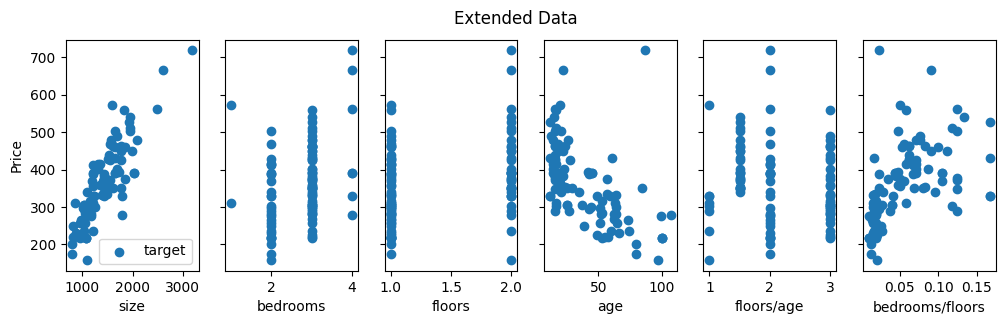

In [141]:
#predict target using normalized features
m = X_train_extended.shape[0]

# plot predictions and targets versus original features
fig,ax=plt.subplots(1,6,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_extended[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features_extended[i])
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("Extended Data")
plt.show()

Let us normalize the new data set

In [136]:
X_norm, X_mean, X_sigma = zscore_normalize_features(X_train_extended)

Let us learn with the new data set

In [170]:
# initialize parameters
initial_w = np.zeros(X_norm.shape[1])
initial_b = 0.
# some gradient descent settings
iterations = 10000
alpha = 0.5
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(3):
    print(f"prediction: {np.dot(X_norm[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 18748.27   
Iteration 1000: Cost   216.83   
Iteration 2000: Cost   216.83   
Iteration 3000: Cost   216.83   
Iteration 4000: Cost   216.83   
Iteration 5000: Cost   216.83   
Iteration 6000: Cost   216.83   
Iteration 7000: Cost   216.83   
Iteration 8000: Cost   216.83   
Iteration 9000: Cost   216.83   
b,w found by gradient descent: 363.16,[111.99 -20.36 -39.51 -29.82   1.47  12.9 ] 
prediction: 297.36, target value: 300.0
prediction: 490.12, target value: 509.8
prediction: 379.15, target value: 394.0


Let us inspect the learning results of the new data set

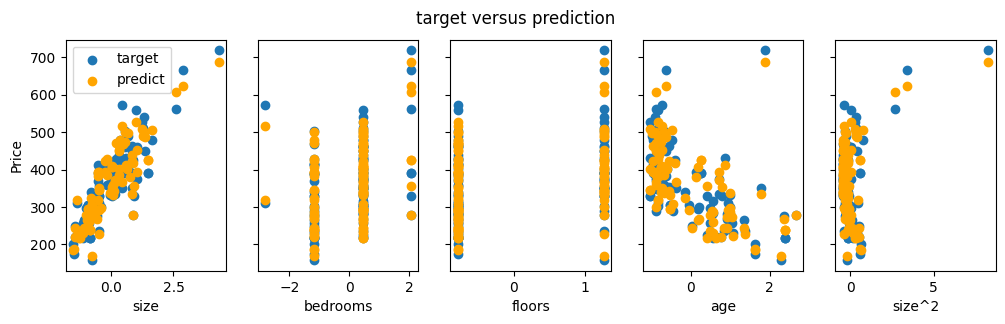

In [171]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_final) + b_final

    # plot predictions and targets versus original features
fig,ax=plt.subplots(1,5,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_extended[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features_extended[i])
    ax[i].scatter(X_train_extended[:,i],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction")
plt.show()

## Exercise 2: Add a new feature and see what happens

* Add a new feature you think it could help to better predict the price of a house, following the same approach used to add "size_per_bedroom" feature. (i) Justify why did you decided to use this feature? (ii) Explore the training cost of the new solution an compare it with the cost of the previous solutions. Is the cost smaller?




---
SUBMIT FEEDBACK


---



---




In [ ]:
feedback("session3_MLR_Exercise2", finished=True, understood=True, comment="No comments")

FEEDBACK SUBMITTED. THANKS!!! :D


# 8 Overfitting



## 8.1 Adding Polynomial Features

Let us add new polynomial features (i.e. $size^2$, $size^3$, etc) to our training data set and see what happens with the cost funciton after running gradient descent.

In [166]:
# Enter the degree of the new polynomial features.
degree = 25

# Create a larger matrix
X_train, y_train = load_house_data()
X_train, _, _ = zscore_normalize_features(X_train)
X_train_extended = np.zeros((X_train.shape[0],X_train.shape[1]+degree-1))

# Copy the training data to the new matrix
if  degree>1:
  X_train_extended[:,:-(degree-1)] = X_train
else:
  X_train_extended = X_train

X_features_extended = ['size','bedrooms','floors','age']

for d in range(2,degree+1):
  #Add the new colum for "size^d"
  X_train_extended[:,X_train.shape[1] + d-2] = X_train[:,0]**d
  #Create new names for the variable
  X_features_extended.append("size^"+str(d))


X_train_extended,_,_ = zscore_normalize_features(X_train_extended)

##  Exercise 3: Polynomial Features

- Add polynomial features using the code above. Start with degree=2 and move to degree=20.

- Look how the Cost function is reduced.

- Do you think we are doing better by having more polynomial functions?

In [172]:
# initialize parameters
initial_w = np.zeros(X_train_extended.shape[1])
initial_b = 0.
# some gradient descent settings
iterations = 100000
alpha = 0.05
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train_extended, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(3):
    print(f"prediction: {np.dot(X_train_extended[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 64006.10   
Iteration 10000: Cost   212.72   
Iteration 20000: Cost   208.59   


KeyboardInterrupt: 

In [173]:
X_features_extended

['size',
 'bedrooms',
 'floors',
 'age',
 'size^2',
 'size^3',
 'size^4',
 'size^5',
 'size^6',
 'size^7',
 'size^8',
 'size^9',
 'size^10',
 'size^11',
 'size^12',
 'size^13',
 'size^14',
 'size^15',
 'size^16',
 'size^17',
 'size^18',
 'size^19',
 'size^20',
 'size^21',
 'size^22',
 'size^23',
 'size^24',
 'size^25',
 'size^26',
 'size^27',
 'size^28',
 'size^29',
 'size^30',
 'size^31',
 'size^32',
 'size^33',
 'size^34',
 'size^35']

In [174]:
X_train_extended[0,:]

array([-0.42,  0.44, -0.79,  0.99, -0.39, -0.14, -0.16, -0.12, -0.12,
       -0.11, -0.11, -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ,
       -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ,
       -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 , -0.1 ,
       -0.1 , -0.1 ])

In [175]:
X_train[0,:]

array([-0.42,  0.44, -0.79,  0.99])

In [176]:
np.mean(X_train,axis=0)

array([-7.51e-17,  4.67e-16, -7.18e-17,  1.30e-16])

In [177]:
np.std(X_train,axis=0)

array([1., 1., 1., 1.])


---
SUBMIT FEEDBACK


---



---




In [ ]:
feedback("session3_MLR_Exercise3", finished=True, understood=True, comment="No comments")

FEEDBACK SUBMITTED. THANKS!!! :D


## 8.2 Measuring Overfitting

We now split the data set in training data set and validation data set.  

In [178]:
#Permutate the data
np.random.seed(123)
perm = np.random.permutation(X_train_extended.shape[0])
X_train_extended = X_train_extended[perm,:]
y_train = y_train[perm]

#Split the data
size_train = 66
X_split_train, y_split_train = X_train_extended[0:size_train,:], y_train[0:size_train]
X_split_val, y_split_val = X_train_extended[size_train:,:], y_train[size_train:]

Let us plot both data sets

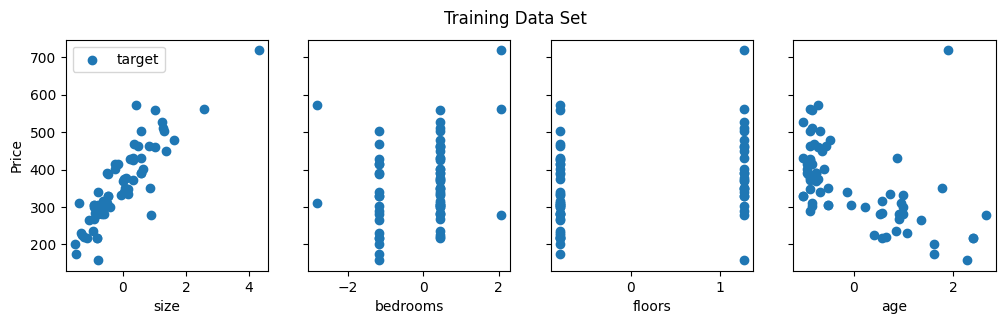

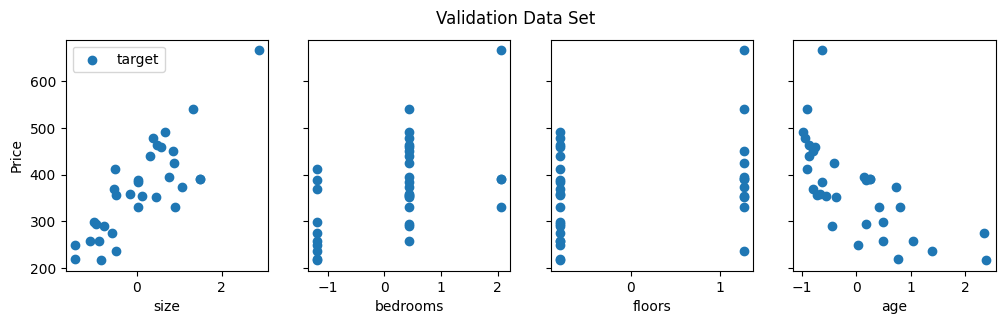

In [180]:
# plot the training data set
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_split_train[:,i],y_split_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("Training Data Set")
plt.show()


# plot predictions and targets versus original features
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_split_val[:,i],y_split_val, label = 'target')
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("Validation Data Set")
plt.show()



The function below implements gradient descent, but it computes both the cost for the training data set and for the validation data set

In [181]:
def gradient_descent_val(X, y, X_val, y_val, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha


    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters
      b (scalar)       : Updated value of parameter
      """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history_train = []
    J_history_test = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history_train.append( cost_function(X, y, w, b))
            J_history_test.append( cost_function(X_val, y_val, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Training Cost {J_history_train[-1]:8.2f}, Test cost {J_history_test[-1]:8.2f}   ")

    return w, b, J_history_train, J_history_test

##  Exercise 4: Measuing Training and Test Error

- Add polynomial features using the code above. Start with degree=2 and move to degree=20.

- Look how the Cost function for the training and the test set evolves.

- Increase and decrease the number of iterations for gradient descent (move it from 10000 to 20000) and observed what happens with the the training and the test cost.

- What do you think is happening?

- Which should be the degree of the included polynomial features?

In [182]:
# initialize parameters
initial_w = np.zeros(X_split_train.shape[1])
initial_b = 0.
# some gradient descent settings
iterations = 20000
alpha = 0.001
# run gradient descent
w_final, b_final, J_hist_train, J_history_test = gradient_descent_val(X_split_train, y_split_train, X_split_val, y_split_val, initial_w, initial_b,
                                                    compute_cost, compute_gradient,
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(3):
    print(f"prediction: {np.dot(X_split_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Training Cost 70253.16, Test cost 72910.93   
Iteration 2000: Training Cost  2128.65, Test cost  2419.92   
Iteration 4000: Training Cost   450.07, Test cost   425.86   
Iteration 6000: Training Cost   281.19, Test cost   292.50   
Iteration 8000: Training Cost   234.24, Test cost   274.74   
Iteration 10000: Training Cost   217.18, Test cost   277.90   
Iteration 12000: Training Cost   209.97, Test cost   286.77   
Iteration 14000: Training Cost   206.41, Test cost   296.73   
Iteration 16000: Training Cost   204.32, Test cost   306.14   
Iteration 18000: Training Cost   202.89, Test cost   314.53   
b,w found by gradient descent: 364.59,[106.93 -17.89 -32.14 -38.11  -5.49   5.05  -6.27  -2.87  -2.44  -1.24
  -0.65  -0.17   0.13   0.34   0.47   0.56   0.62   0.66   0.69   0.71
   0.72   0.73   0.73   0.74   0.74   0.74   0.74   0.74   0.74   0.74
   0.74   0.74   0.74   0.74   0.74   0.74   0.74   0.74] 
prediction: 717.97, target value: 718.2
prediction: 504.82, targe

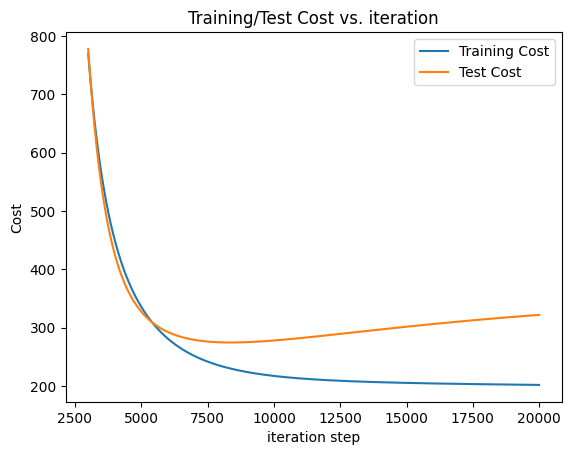

In [183]:
# plot cost versus iteration
start = 3000
plt.plot(np.arange(start,iterations,1), J_hist_train[start:], label = "Training Cost")
plt.plot(np.arange(start,iterations,1), J_history_test[start:], label = "Test Cost")
plt.title("Training/Test Cost vs. iteration")
plt.ylabel('Cost')
plt.xlabel('iteration step')
plt.legend()
plt.show()


---
SUBMIT FEEDBACK


---



---




In [ ]:
feedback("session3_MLR_Exercise4", finished=True, understood=True, comment="No comments")

FEEDBACK SUBMITTED. THANKS!!! :D
